In [22]:
import pandas as pd
from models.Hermen.model_BE2 import model_BE2
import numpy as np
from graphmodels.validation import score_model, plot_diagnostic


FBS = pd.read_csv('models/Hermen/data/FBS.csv')
QC = pd.read_csv('models/Hermen/data/QC.csv').drop(columns=['Item']).rename(columns={'FBS_item': 'Item'})
RL = pd.read_csv('models/Hermen/data/RL.csv').dropna(subset=['GGI_code'])

QC = QC.groupby(['Item', 'GGI_code', 'Year', 'Area']).mean().reset_index()

In [5]:
# Aux functions, to improve. The idea is to run the model on the full database at once rather than spliiting all the stuff. Perharps using dataframe around
def pivot(df):
    return df.pivot(index=['Area', 'Year','Item'], columns='GGI_code', values='Value')

def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].dropna()#.fillna(0)
    return X

def FBS_QC_RL_to_X(FBS, QC, RL):
    
    
    X = {}
    
    FBS_dict = df_to_dict(pivot(FBS))
    QC_dict = df_to_dict(pivot(QC))
    RL_dict = RL[['Area', 'Year', 'GGI_code', 'Value']].pivot(index=['Area', 'Year'], columns='GGI_code', values='Value')
    RL_dict = df_to_dict(RL_dict)
    
    for dictionnary in [FBS_dict, QC_dict, RL_dict]:
        X.update(dictionnary)
    
            
    crop_group = FBS.dropna()[FBS.dropna()['group'] == 'crop'].Item.unique()
    animal_group = FBS.dropna()[FBS.dropna()['group'] == 'animal'].Item.unique()
    
    X['P'] = X['P'].dropna()
    X['crop_group'] = crop_group
    X['animal_group'] = animal_group

    X['FWPPi'] = 100
    X['FWCRi'] = 0
    X['CRfd'] = 1
    X['CD_corr'] = 1
    X['R_rate'] = 0

    
    # To clean up
    FDi = X['FDi'].reset_index('Item')

    # to check
    X['TCLD_baseline'] = X['TCLDi'].groupby(level=['Area', 'Year']).sum()
    
    X['FMi'] = X['FDi'].loc[:, :, crop_group] / X['FDi'].loc[:, :, crop_group].groupby(level=['Area', 'Year']).sum()
    
    X['P'] = X['P'].reset_index('Item', drop=True).drop_duplicates()
    

    return X


data_dict = FBS_QC_RL_to_X(FBS, QC, RL)

In [10]:
X, y_true = get_X_y_from_data(model_BE2, data_dict)
res = model_BE2.run(X)

In [11]:
def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_() + model.outputs_() if key in data_dict}
    return X, y

In [12]:
score_model(model_BE2, X, y_true)

Empty DataFrame
Columns: []
Index: []

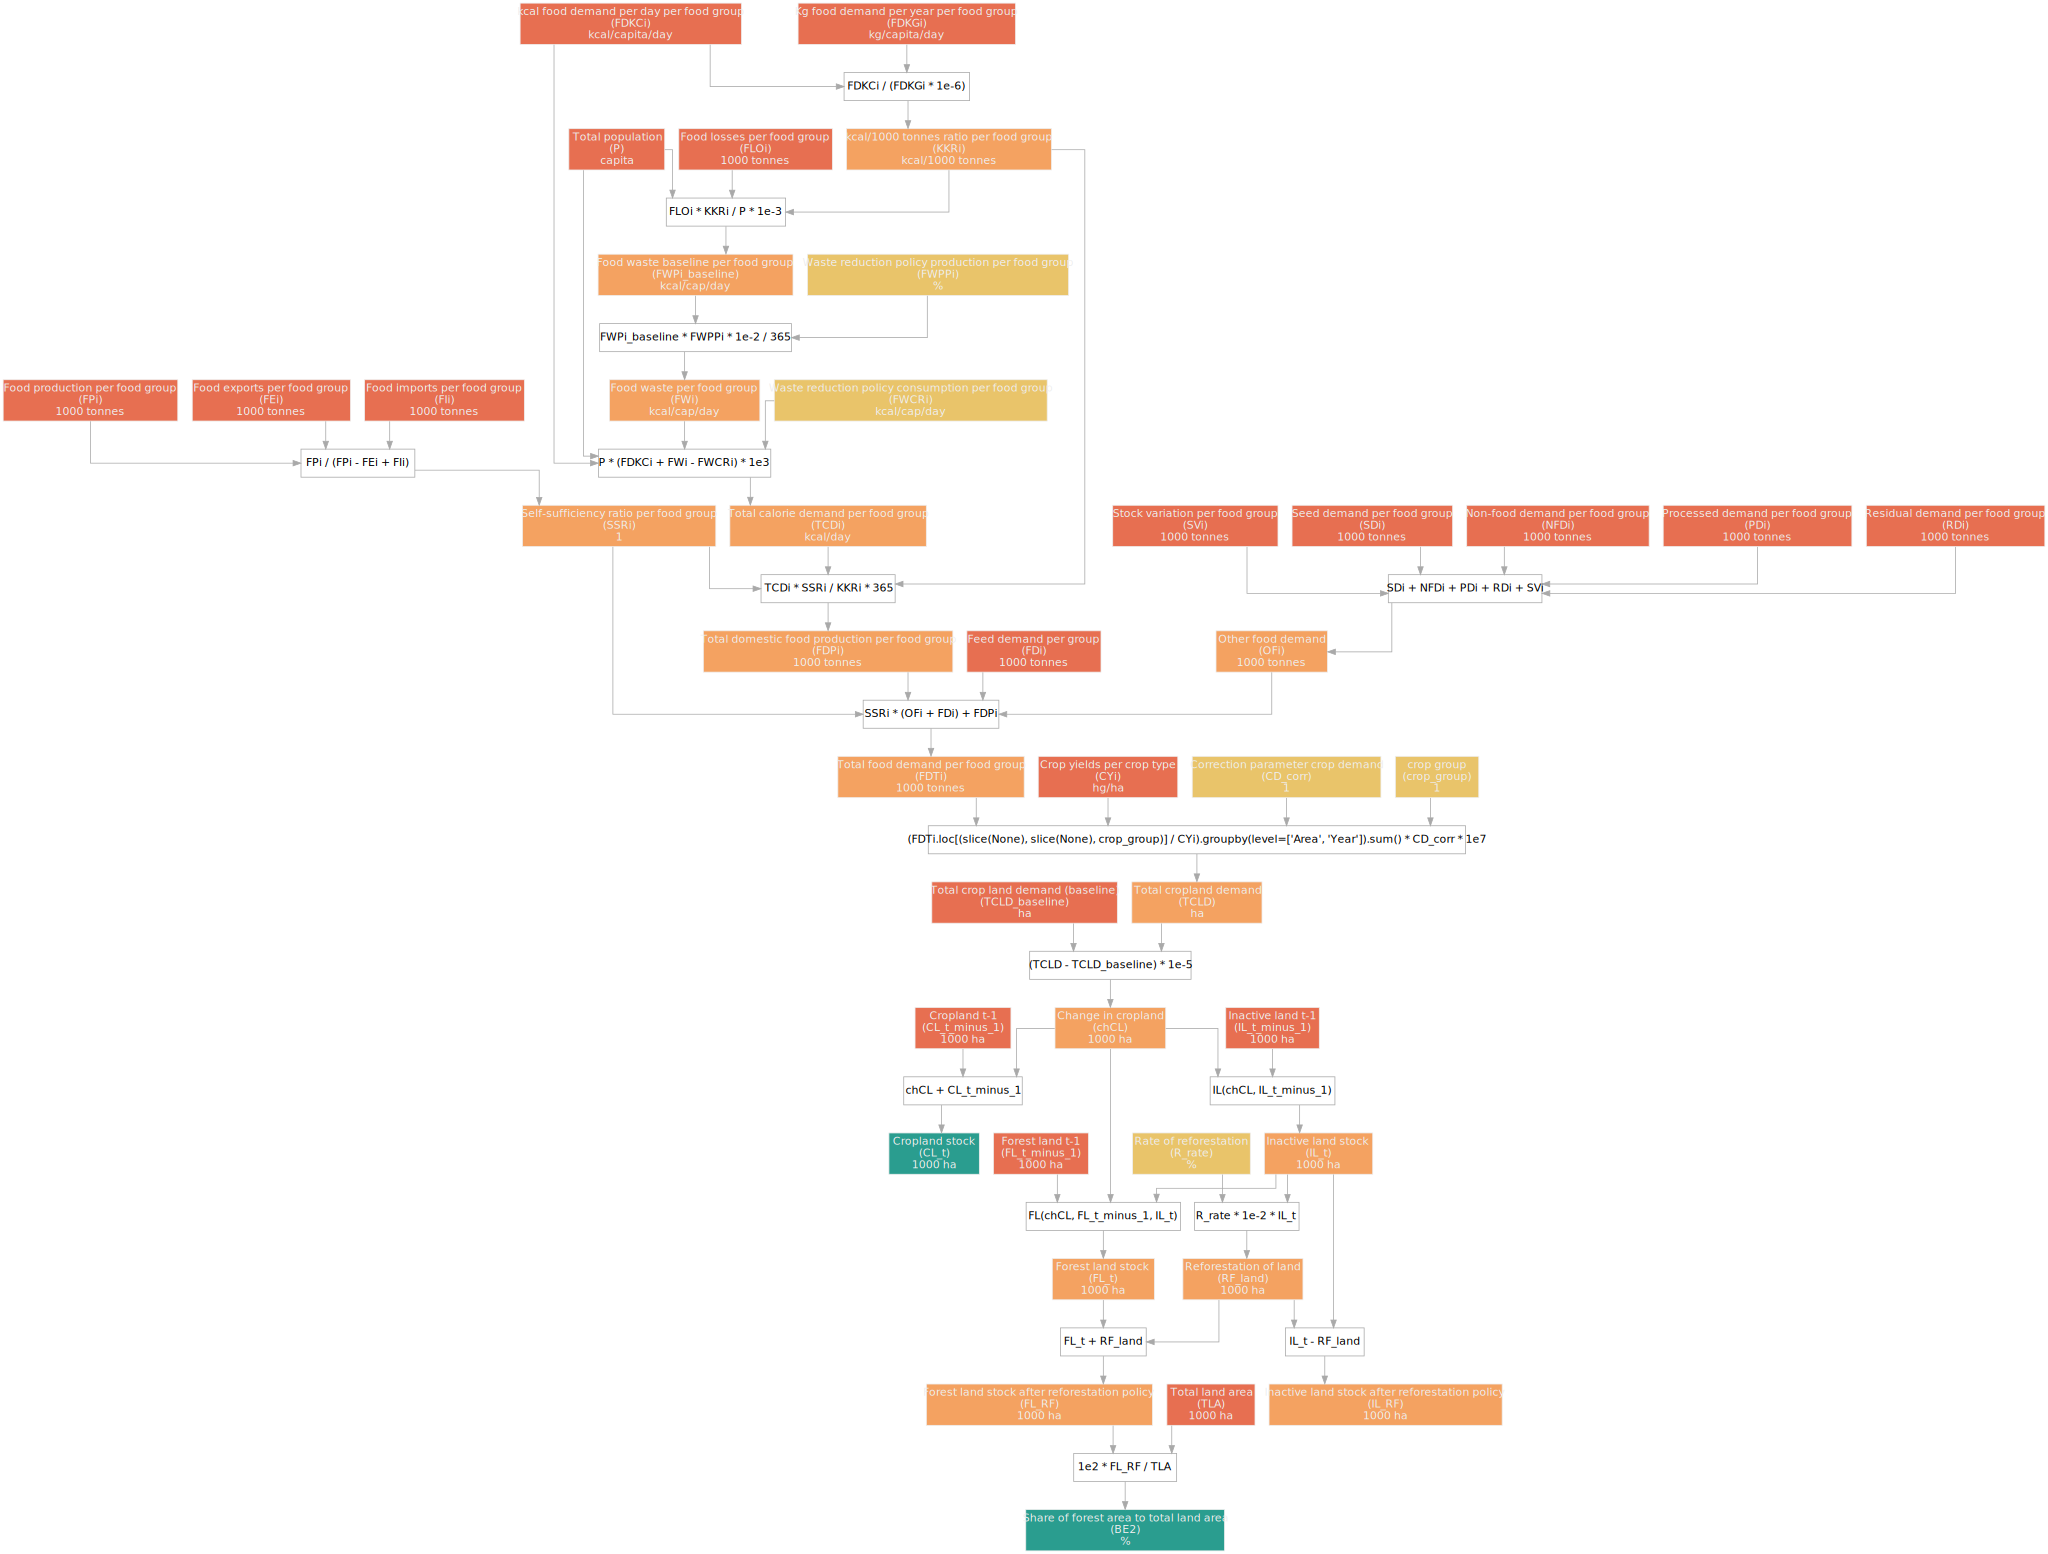

In [13]:
model_BE2.draw()

# Modified + DataUpdate

In [14]:
from graphmodels.graphmodel import converte_to_format, GraphModel, concatenate_graph_specs
from database import select_dataset
from graphmodels.validation import check_model, check_variable_graph


fbs_data = select_dataset('foodbalancesheet')
population_data = select_dataset('population')
crops_data = select_dataset('crops')

In [15]:
def pivot(df):
    return df.pivot(index=['Area', 'Year','Item'], columns='Variable', values='Value')

def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].dropna()#.fillna(0)
    return X

fbs_data_dict = df_to_dict(pivot(fbs_data))
fbs_data_dict['Pop'] = population_data.pivot(index=['Area', 'Year'], columns='Variable', values='Value')['P']
fbs_data_dict.update(df_to_dict(pivot(crops_data)))
crop_group = fbs_data[fbs_data['group'] == 'crop'].Item.unique()
fbs_data_dict['crop_group'] = crop_group

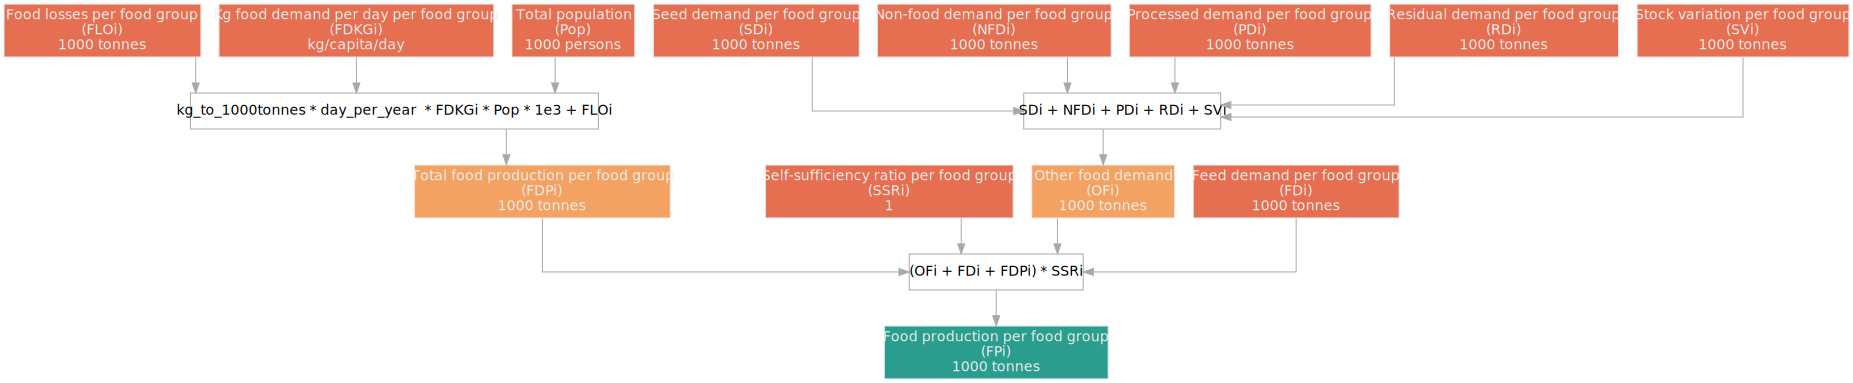

In [16]:
# To check naming, confusing with demand/prod + total not total
kg_to_1000tonnes = 1e-6
day_per_year = 365

FPi_nodes = {'FLOi': {'type': 'input',
                       'unit': '1000 tonnes',
                       'name': 'Food losses per food group'},
              'FDKGi': {'type': 'input',
                        'unit': 'kg/capita/day',
                        'name': 'Kg food demand per day per food group'},
              'SSRi': {'type': 'input',
                       'unit': '1',
                       'name': 'Self-sufficiency ratio per food group',
                       },
              'FDPi': {'type': 'variable',
                       'unit': '1000 tonnes',
                       'name': 'Total food production per food group',
                       'computation': lambda FDKGi, Pop, FLOi, **kwargs: kg_to_1000tonnes * day_per_year  * FDKGi * Pop * 1e3 + FLOi
                       },
              'OFi': {'type': 'variable',
                      'unit': '1000 tonnes',
                      'name': 'Other food demand',
                      'computation': lambda SDi, NFDi, PDi, RDi, SVi, **kwargs: SDi + NFDi + PDi + RDi + SVi
                      },
              'SDi': {'type': 'input',
                      'unit': '1000 tonnes',
                      'name': 'Seed demand per food group'},
              'NFDi': {'type': 'input',
                       'unit': '1000 tonnes',
                       'name': 'Non-food demand per food group'},
              'PDi': {'type': 'input',
                      'unit': '1000 tonnes',
                      'name': 'Processed demand per food group'},
              'RDi': {'type': 'input',
                      'unit': '1000 tonnes',
                      'name': 'Residual demand per food group'},
              'SVi': {'type': 'input',
                      'unit': '1000 tonnes',
                      'name': 'Stock variation per food group'},
              'FPi': {'type': 'output',
                       'name': 'Food production per food group',
                       'unit': '1000 tonnes',
                       'computation': lambda SSRi, OFi, FDi, FDPi, **kwargs: (OFi + FDi + FDPi) * SSRi
                       },
              'FDi': {'type': 'input',
                      'unit': '1000 tonnes',
                      'name': 'Feed demand per food group'},
              'Pop': {'type': 'input', 'unit': '1000 persons', 'name': 'Total population'}}

model_FPi = GraphModel(FPi_nodes)

model_FPi.draw()

In [23]:
X, y_true = get_X_y_from_data(model_FPi, fbs_data_dict)
score_model(model_FPi, X, y_true)

r2  correlation       rmse Variable
0  1.0          1.0  33.016574      FPi

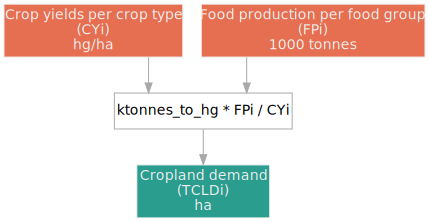

In [28]:
ktonnes_to_hg = 1e7
# PROBLEM WITH VALUES IN THE DATASET

TCLDi_nodes = {'TCLDi': {'type': 'output',
                   'name': 'Cropland demand',
                   'unit': 'ha',
                   'computation': lambda CYi, FPi, **kwargs: ktonnes_to_hg * FPi / CYi
                       },
          'CYi': {'type': 'input',
                  'unit': 'hg/ha',
                  'name': 'Crop yields per crop type'},
          'FPi': {'type': 'input',
                  'name': 'Food production per food group',
                  'unit': '1000 tonnes'},
        }

model_TCLDi = GraphModel(TCLDi_nodes)

model_TCLDi.draw()

In [29]:
X, y_true = get_X_y_from_data(model_TCLDi, fbs_data_dict)
score_model(model_TCLDi, X, y_true)

r2  correlation          rmse Variable
0  0.589906       0.9027  3.098178e+12    TCLDi

In [30]:
plot_diagnostic(model_TCLDi, X, y_true, 'TCLDi')

In [31]:
def FL(chCL, FL_t_minus_1, IL_t_minus_1):
    '''To check'''
    df = pd.concat([chCL, FL_t_minus_1, IL_t_minus_1], axis=1).dropna()
    df.columns = ['chCL', 'FL_t_minus_1', 'IL_t_minus_1']
    df['FL'] = df['FL_t_minus_1']

    df[(df.chCL > 0) & (df.IL_t_minus_1 - df.chCL) < 0]['FL'] += df['IL_t_minus_1'] - df['chCL']

    return df['FL']


def IL(chCL, IL_t_minus_1):
    '''To check'''
    df = pd.concat([chCL, IL_t_minus_1], axis=1).dropna()
    df.columns = ['chCL', 'IL_t_minus_1']
    df['IL'] = df['IL_t_minus_1'] - df['chCL']
    df[(df.chCL > 0) & (df.IL_t_minus_1 - df.chCL) < 0] = 0
    return df['IL']


CH_IL_FL_nodes = {'chCL': {'type': 'input', 'name': 'Change in cropland', 'unit': '1000 ha'},
                  'CL_t_minus_1': {'type': 'input', 'unit': '1000 ha', 'name': 'Cropland t-1'},
                  'IL_t_minus_1': {'type': 'input',
                                   'unit': '1000 ha',
                                   'name': 'Inactive land t-1'},
                  'FL_t_minus_1': {'type': 'input',
                                   'unit': '1000 ha',
                                   'name': 'Forest land t-1'},
                  'CL_t': {'type': 'output',
                           'name': 'Cropland stock',
                           'unit': '1000 ha',
                           'computation': lambda chCL, CL_t_minus_1, **kwargs: chCL + CL_t_minus_1
                           },
                  'IL_t': {'type': 'output',
                           'name': 'Inactive land stock',
                           'unit': '1000 ha',
                           'computation': lambda chCL, IL_t_minus_1, **kwargs: IL(chCL, IL_t_minus_1)
                           },
                  'FL_t': {'type': 'output',
                           'name': 'Forest land stock',
                           'unit': '1000 ha',
                           'computation': lambda chCL, FL_t_minus_1, IL_t, **kwargs: FL(chCL, FL_t_minus_1, IL_t)
                           }
                  }

In [32]:
landuse_df = select_dataset('landuse').replace({'Variable': {'CL_t_minus_1': 'CL',
                                                             'IL_t_minus_1': 'IL',
                                                             'FL_t_minus_1': 'FL'}})

test = landuse_df.query("Variable in ['FL', 'CL', 'IL']").pivot(index=['Area', 'Year'], columns=['Variable'], values='Value')

test['delta_CL'] = test.groupby(level=['Area'])['CL'].diff(periods=1)#.rename(columns={'CL': 'delta_CL'})
test['FL_t+1'] = test.groupby(level=['Area'])['FL'].shift(periods=-1)#.rename(columns={'CL': 'delta_CL'})
test['IL_t+1'] = test.groupby(level=['Area'])['IL'].shift(periods=-1)#.rename(columns={'CL': 'delta_CL'})

def FL(chCL, FL_t_minus_1, IL_t_minus_1):
    '''To check'''
    df = pd.concat([chCL, FL_t_minus_1, IL_t_minus_1], axis=1).dropna()
    df.columns = ['chCL', 'FL_t_minus_1', 'IL_t_minus_1']
    df['FL'] = df['FL_t_minus_1']

    df[(df.chCL > 0) & (df.IL_t_minus_1 - df.chCL) < 0]['FL'] += df['IL_t_minus_1'] - df['chCL']

    return df['FL']


def IL(chCL, IL_t_minus_1):
    '''To check'''
    df = pd.concat([chCL, IL_t_minus_1], axis=1).dropna()
    df.columns = ['chCL', 'IL_t_minus_1']
    df['IL'] = df['IL_t_minus_1'] - df['chCL']
    df[(df.chCL > 0) & (df.IL_t_minus_1 - df.chCL) < 0] = 0
    return df['IL']

In [33]:
test

Variable              CL        FL  IL  delta_CL    FL_t+1  IL_t+1
Area        Year                                                  
Afghanistan 1961  7700.0       NaN NaN       NaN       NaN     NaN
            1962  7760.0       NaN NaN      60.0       NaN     NaN
            1963  7810.0       NaN NaN      50.0       NaN     NaN
            1964  7873.0       NaN NaN      63.0       NaN     NaN
            1965  7875.0       NaN NaN       2.0       NaN     NaN
...                  ...       ...  ..       ...       ...     ...
Zimbabwe    2014  4100.0  17721.00 NaN       0.0  17674.93     NaN
            2015  4100.0  17674.93 NaN       0.0  17628.86     NaN
            2016  4100.0  17628.86 NaN       0.0  17582.79     NaN
            2017  4100.0  17582.79 NaN       0.0  17536.72     NaN
            2018  4100.0  17536.72 NaN       0.0       NaN     NaN

[12402 rows x 6 columns]

In [36]:
import plotly.express as px

In [37]:
test = test.reset_index().query("Year > 2000")

In [38]:
px.scatter(test.query("Area in ['Germany']").reset_index(), x='Year', y='FL', color='Area')

In [39]:
px.scatter(test.query("Area in ['Germany',]").reset_index(), x='Year', y='CL', color='Area')


In [40]:
px.scatter(test.query("Area in ['Germany',]").reset_index(), x='Year', y='IL', color='Area')


In [42]:
test['delta_FL'] = test['FL_t+1'] - test['FL']

In [56]:
test.query("Area == 'France'")

Variable  index    Area  Year         CL       FL        IL  delta_CL  \
1330       4014  France  2001  19480.600  15401.1  1342.300   -14.500   
1331       4015  France  2002  19499.800  15514.2  1277.100    19.200   
1332       4016  France  2003  19470.800  15627.3  1328.000   -29.000   
1333       4017  France  2004  19478.800  15740.4  1152.900     8.000   
1334       4018  France  2005  19488.200  15853.5  1296.600     9.400   
1335       4019  France  2006  19435.600  15966.6  1262.400   -52.600   
1336       4020  France  2007  19358.300  16079.7  1199.800   -77.300   
1337       4021  France  2008  19320.000  16192.8   733.000   -38.300   
1338       4022  France  2009  19283.400  16305.9   660.700   -36.600   
1339       4023  France  2010  19311.800  16419.0   623.200    28.400   
1340       4024  France  2011  19281.600  16502.4   547.300   -30.200   
1341       4025  France  2012  19285.500  16585.8   498.900     3.900   
1342       4026  France  2013  19302.200  16669.2   486.600    16.700   
1343       4027  France  2014  19328.300  16752.6   466.400    26.100   
1344       4028  France  2015  19465.000  16836.0   461.100   136.700   
1345       4029  France  2016  19348.036  16919.4   468.867  -116.964   
1346       4030  France  2017  19463.775  17002.8   485.038   115.739   
1347       4031  France  2018  19132.200  17086.2   485.500  -331.575   

Variable   FL_t+1    IL_t+1  delta_FL  
1330      15514.2  1277.100     113.1  
1331      15627.3  1328.000     113.1  
1332      15740.4  1152.900     113.1  
1333      15853.5  1296.600     113.1  
1334      15966.6  1262.400     113.1  
1335      16079.7  1199.800     113.1  
1336      16192.8   733.000     113.1  
1337      16305.9   660.700     113.1  
1338      16419.0   623.200     113.1  
1339      16502.4   547.300      83.4  
1340      16585.8   498.900      83.4  
1341      16669.2   486.600      83.4  
1342      16752.6   466.400      83.4  
1343      16836.0   461.100      83.4  
1344      16919.4   468.867      83.4  
1345      17002.8   485.038      83.4  
1346      17086.2   485.500      83.4  
1347          NaN       NaN       NaN

In [55]:
px.scatter(test.query("Area == 'France'"), x='IL', y='delta_FL')


In [53]:
px.scatter(test, x='IL', y='delta_FL')


In [27]:

def plot_computation_vs_baseline(baseline, computation):
    df = pd.concat([baseline, computation], axis=1).dropna()
    df.columns = ['baseline', 'computation']
    fig = px.scatter(df.reset_index(), x=f'baseline', y=f'computation', hover_data=['Area', 'Year'], trendline='ols')
    return fig

FL_comp = FL(test['delta_CL'], test['FL'], test['IL'])
plot_computation_vs_baseline(test['FL_t+1'], FL_comp)


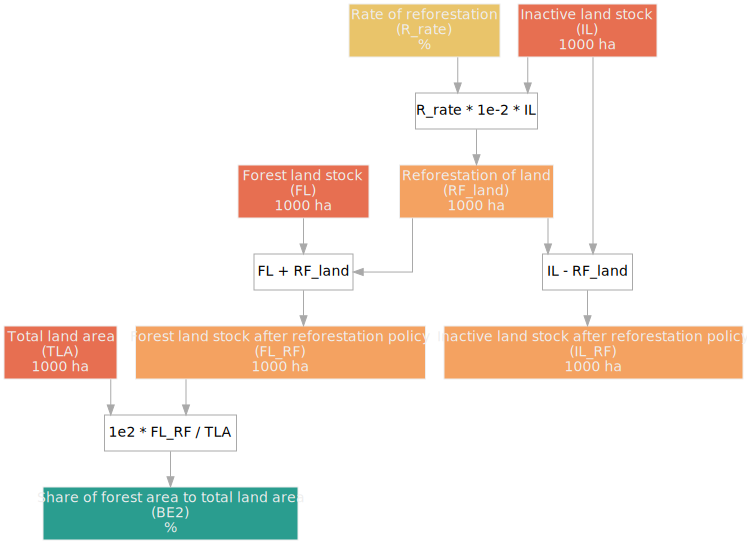

In [21]:
BE2_nodes = {'TLA': {'type': 'input', 'unit': '1000 ha', 'name': 'Total land area'},
             'FL': {'type': 'input', 'unit': '1000 ha', 'name': 'Forest land stock'},
             'IL': {'type': 'input', 'unit': '1000 ha', 'name': 'Inactive land stock'},
             'R_rate': {'type': 'parameter', 'unit': '%', 'name': 'Rate of reforestation'},
             'RF_land': {'type': 'variable',
                         'name': 'Reforestation of land',
                         'unit': '1000 ha',
                         'computation': lambda R_rate, IL, **kwargs: R_rate * 1e-2 * IL
                         },
             'FL_RF': {'type': 'variable',
                       'name': 'Forest land stock after reforestation policy',
                       'unit': '1000 ha',
                       'computation': lambda FL, RF_land, **kwargs: FL + RF_land
                       },
             'IL_RF': {'type': 'variable',
                       'name': 'Inactive land stock after reforestation policy',
                       'unit': '1000 ha',
                       'computation': lambda IL, RF_land, **kwargs: IL - RF_land
                       },
             'BE2': {'type': 'output',
                     'name': 'Share of forest area to total land area',
                     'unit': '%',
                     'computation': lambda FL_RF, TLA, **kwargs: 1e2 * FL_RF / TLA
                     }
             }

BE2_model = GraphModel(BE2_nodes)
BE2_model.draw()

In [22]:
landuse_dict = df_to_dict(landuse_df.pivot(index=['Area', 'Year'], columns='Variable', values='Value'))
landuse_dict['R_rate'] = 0
X, y_true = get_X_y_from_data(BE2_model, landuse_dict)
y_true['BE2'] = X['FL'] / X['TLA'] * 1e2

In [71]:
TLA_comp = (landuse_dict['CL'] + landuse_dict['IL'] + landuse_dict['FL']).dropna()

In [72]:

def plot_computation_vs_baseline(baseline, computation):
    df = pd.concat([baseline, computation], axis=1).dropna()
    df.columns = ['baseline', 'computation']
    fig = px.scatter(df.reset_index(), x=f'baseline', y=f'computation', hover_data=['Area', 'Year'], trendline='ols')
    return fig

plot_computation_vs_baseline(landuse_dict['TLA'], TLA_comp)

In [23]:
check_model(BE2_model, X, y_true)

Checking computations:
BE2 r2: 1.0 | BE2 corr: 0.9999999999999998
